# Logistic Regression (Bigrams)

**BrainStation**

## Introduction

In this notebook, we will employing a logistic regression model to find bigrams that are predictive of positive and negative reviews. We will exclude the drug reviews for Ozempic so that the model does not contain words from that corpus. We will also count the frequency of those words in the Ozempic drug reviews.

***

## Table of Contents

- [The Dataset](#the-dataset)
- [Vectorizing the Data](#vectorizing)
- [Fitting a Classifier](#classifier)
- [Comparing LR Coefficients to Ozempic Reviews](#ozempic)
- [Conclusion](#conclusion)

***

## The Dataset <a class="anchor" id="the-dataset"></a>

Let's import the relevant packages to analyze the data.

In [35]:
# Imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter
import string
import re

In [36]:
cd /Users/justinanguyen/Desktop/BrainStation/Projects/Capstone/Justina_Nguyen_Capstone_Submission

/Users/justinanguyen/Desktop/BrainStation/Projects/Capstone/Justina_Nguyen_Capstone_Submission


Let's take a look at our data.

In [37]:
# Reading the csv file into a dataframe
df = pd.read_csv('./preprocessed_drug_reviews_for_lr.csv', index_col=0)

# Checking the first 5 rows of the dataframe
df.head()

,date,review,rating,upvotes,page,year,month,sentiment,drugDuration,Alli (orlistat),Contrave (bupropion / naltrexone),Qsymia (phentermine / topiramate),Saxenda (liraglutide),Wegovy (semaglutide),Xenical (orlistat)
0,2023-02-27,I have been taking Wegovy for 1 week and 2 day...,10,622,1,2023,2,1,1,0,0,0,0,1,0
1,2023-04-03,Starting week 9 with the second injection of 1...,7,216,1,2023,4,0,0,0,0,0,0,1,0
2,2023-04-18,Tomorrow I will take my 3rd shot of .5mg (prev...,10,167,1,2023,4,1,0,0,0,0,0,1,0
4,2022-02-06,6 months. -65 pounds. Hypertension gone. Pre D...,10,709,1,2022,2,1,0,0,0,0,0,1,0
5,2022-11-05,I started at a size XXL/pants size 16 and 213l...,10,356,1,2022,11,1,0,0,0,0,0,1,0


In [38]:
# Checking the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4656 entries, 0 to 5232
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   date                               4656 non-null   object
 1   review                             4656 non-null   object
 2   rating                             4656 non-null   int64 
 3   upvotes                            4656 non-null   int64 
 4   page                               4656 non-null   int64 
 5   year                               4656 non-null   int64 
 6   month                              4656 non-null   int64 
 7   sentiment                          4656 non-null   int64 
 8   drugDuration                       4656 non-null   int64 
 9   Alli (orlistat)                    4656 non-null   int64 
 10  Contrave (bupropion / naltrexone)  4656 non-null   int64 
 11  Qsymia (phentermine / topiramate)  4656 non-null   int64 
 12  Saxend

In [39]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

This dataset has 4656 rows and 15 columns.


## Vectorizing the Data <a class="anchor" id="vectorizing"></a>

We want use the `my_preprocessor2` function that we created in the previous notebook to process the text in the `review` column. 

Before that, we need to identify the independent and dependent variables.

In [40]:
# Identify the independent and dependent variables
X = df['review']
y = df['sentiment']

In [41]:
# modified preprocessor to exclude certain words
def my_preprocessor2(text):
    '''
    This function takes text as input. It first parses through sentences in order to help part-of-speech (POS) 
    tagging work best as good POS tags help out lemmatization. Each sentence gets broken into tokens (words),
    lemmatized, converted to lowercase, then stripped of non alphabetic or space characters (which there 
    shouldn't be). Then, any zero length strings or stopwords are removed and the result for the fully processed 
    sentence is appended to the final output.
    
    Parameters:
    -----------
    text: any kind of text
    
    Returns:
    --------
    output: a processed and clean list of words
    
    ''' 
    # Create dictionary for the part-of-speech tagging
    pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}
    lemmatizer = WordNetLemmatizer()
    # List of english stopwords in lowercase
    stops = set(stopwords.words("english"))
    # remove drug name and common words
    stops.update(["wegovy", "ozempic", "saxenda", "contrave", "xenical", "alli", "qsymia", "nt", "lb", "lbs",\
                  "oz", "u", "etc", "mg", "take", "pound", "go", "nd", "th", "kg", "ago", "day", "week",\
                  "month", "get", "happen", "yet", "however", "l", "yo"])
    # First break into sentences to get pos tagging to work best
    as_sent = sent_tokenize(text,language='english')
    processed = []
    for sent in as_sent:
        # Break each sentence into words
        tokens = word_tokenize(sent)
        # Get pos tags for lemmatization
        pos_tags = nltk.pos_tag(tokens)
        mapped_tags = list((tag[0],pos_map.get(tag[1][0],wordnet.NOUN)) for tag in pos_tags)
        lemmas = list(lemmatizer.lemmatize(*tagged) for tagged in mapped_tags)
        # Convert to lower after lemmatization
        as_str = " ".join(list(lemma.lower() for lemma in lemmas))
        # Remove unwanted punctuation and numbers
        cleaned = "".join(char for char in as_str if char in "abcdefghijklmnopqrstuvwxyz ")
        # Double check no empty strings and add to processed
        cleaned = list(word for word in cleaned.split() if len(word) > 0 and word not in stops )
        processed.extend(cleaned)
    return processed

Now that we have the `my_preprocessor2` function, we can used function in the TF-IDF vector to fit the data. We also want to be looking for bigrams (2-words) in the dataset. The fitted vectorizer is used to transform the input data (X) into a numerical representation. The transform method converts each document into a vector representation using the learned vocabulary.

In [42]:
# Instantiate the vectorizer
vectorized = TfidfVectorizer(preprocessor = my_preprocessor2, # use our custom preprocessor
                             tokenizer = lambda l:l,          # skip tokenization, our preprocessor returns words
                             min_df = 20,                     # require words be in at least 20 documents
                             max_features = 500,              # limiting the maximum number of features to 500        
                             ngram_range = (2,2))             # want bigrams

# Fit the vectorizer
vectorized = vectorized.fit(X)

# Transform the vectorizer
reviews_transformed = vectorized.transform(X)


/Users/justinanguyen/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



## Fitting a Classifier <a class="anchor" id="classifier"></a>

Now that our `review` column has been vectorized, we can fit it to a logistic regression model. This will allow us to see the highest model coefficients indicating positive sentiment and the lowest model coefficients indicating negative sentiment.

In [43]:
# Fitting a model
logreg = LogisticRegression()
logreg.fit(reviews_transformed, y)

LogisticRegression()

We can create a dataframe of the logistic regression coefficients and their features. We can extract the top 20 rows and plot them. Higher coefficients indicate a stronger influence of the corresponding independent variable on the probability of the event of interest occurring. In this case, we are looking for words indicating positive sentiment.

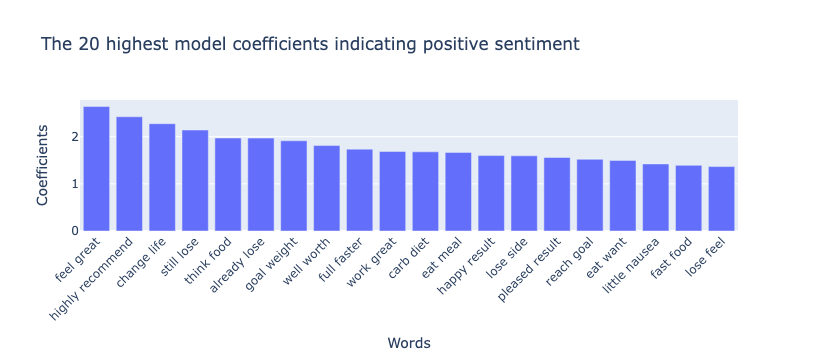

In [44]:
# Create a dataframe of the coeffients and the features
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index = vectorized.get_feature_names_out()
).sort_values("coefficients", ascending=False)

# Select the top 20 rows
top_20_positive = word_counts.head(20)

# Create the bar plot
fig = px.bar(top_20_positive,
             x=top_20_positive.index,
             y='coefficients',
             labels={'coefficients': 'Coefficients', 'index': 'Words'},
             title="The 20 highest model coefficients indicating positive sentiment"
)

# Rotate x-axis labels by 45 degrees
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()

We can also get the bottom 20 rows which would indicate negative sentiment.

In [45]:
# Sort the DataFrame by 'coefficients' column in ascending order and select the top 20 rows
top_20_negative = word_counts.sort_values("coefficients", ascending=True).head(20)

# Create the bar plot
fig = px.bar(top_20_negative, x=top_20_negative.index, y="coefficients",
             title="The 20 lowest model coefficients indicating negative sentiment",
             labels={"coefficients": "Coefficients", "index": "Words"})

# Rotate x-axis labels by 45 degrees
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()


With the graphs above show the 20 highest model coefficients indicating positive sentiment and the 20 lowest model coefficients indicating negative sentiment, we can see if any of them properly indicate positive / negative sentiment. 

To see the comparison between these drugs to Ozempic, we can take those features and see how many of them appear in the Ozempic (semaglutide) reviews.

## Comparing LR Coefficients to Ozempic Reviews <a class="anchor" id="ozempic"></a> 

We first need to read in the CSV file containing the Ozempic (semaglutide) reviews.

In [46]:
# Reading the csv file into a dataframe
drug_df = pd.read_csv('./clean_preprocessed_drug_reviews.csv', index_col=0)

# Checking the first 5 rows of the dataframe
drug_df.head()

,uniqueID,duration,date,drugName,review,rating,upvotes,drug,page,year,month
0,jwillou,Taken for less than 1 month,2023-02-27,Wegovy (semaglutide),I have been taking Wegovy for 1 week and 2 day...,10,622,semaglutide,1,2023,2
1,Slow...,Taken for 1 to 6 months,2023-04-03,Wegovy (semaglutide),Starting week 9 with the second injection of 1...,7,216,semaglutide,1,2023,4
2,KS in...,Taken for 1 to 6 months,2023-04-18,Wegovy (semaglutide),Tomorrow I will take my 3rd shot of .5mg (prev...,10,167,semaglutide,1,2023,4
3,Smithy...,Taken for 1 to 6 months,2023-03-14,Ozempic (semaglutide),I was hesitant to try Ozempic for weight loss ...,10,231,semaglutide,1,2023,3
4,Philly,Taken for 6 months to 1 year,2022-02-06,Wegovy (semaglutide),6 months. -65 pounds. Hypertension gone. Pre D...,10,709,semaglutide,1,2022,2


To make the analysis easier, we will keep the rows where `drugName` is `Ozempic (semaglutide)` and drop all the other rows.

In [47]:
# Keep only rows where drugName is Ozempic (semaglutide)
drug_df = drug_df[drug_df['drugName'] == 'Ozempic (semaglutide)']

Then, we can clean and preprocess the data to get the vocabulary.

In [48]:
clean_drug_reviews = []
word_counts = {'Ozempic (semaglutide)': Counter()}

# Cleans and splits text
# And counts the words
for review in drug_df['review']:
    # Join the preprocessed words from a review into a single string with words separated by a space
    clean = " ".join(my_preprocessor2(review))  
    # Add the preprocessed review to the list of clean reviews
    clean_drug_reviews.append(clean) 
    # Split the preprocessed review into individual words
    words = clean.split()
    # Adds the individuals words to the list of words
    word_counts['Ozempic (semaglutide)'].update(words)

We can loop through the 20 words that indicate positive sentiment and count the frequency it appears in the Ozempic drug reviews. We can do the same for the 20 words that indicate negative sentiment.

In [49]:
# List of words to search for
pos_search_words = top_20_positive.index.tolist()

# Create an empty list to store the word counts
pos_word_counts_list = []

# Iterate over each word in the search_words list
for word in pos_search_words:
    if word in word_counts['Ozempic (semaglutide)']:
        count = word_counts['Ozempic (semaglutide)'][word]
        pos_word_counts_list.append({'Word': word, 'Count': count})
    else:
        pos_word_counts_list.append({'Word': word, 'Count': 0})

# Create a DataFrame from the word_counts_list
pos_word_counts_df = pd.DataFrame(pos_word_counts_list)

# Normalize the counts
total_count = pos_word_counts_df['Count'].sum()
pos_word_counts_df['Normalized_Count'] = round(pos_word_counts_df['Count'] / total_count, 3)

# Plot the normalized word counts
fig = px.bar(pos_word_counts_df, x='Word', y='Normalized_Count',\
             title="Normalized frequencies of the 20 highest model coefficients indicating positive sentiment",\
             color='Word')

# Show the plot
fig.show()

# Print the dataframe
print(pos_word_counts_df)

                Word  Count  Normalized_Count
0         feel great      0               NaN
1   highly recommend      0               NaN
2        change life      0               NaN
3         still lose      0               NaN
4         think food      0               NaN
5       already lose      0               NaN
6        goal weight      0               NaN
7         well worth      0               NaN
8        full faster      0               NaN
9         work great      0               NaN
10         carb diet      0               NaN
11          eat meal      0               NaN
12      happy result      0               NaN
13         lose side      0               NaN
14    pleased result      0               NaN
15        reach goal      0               NaN
16          eat want      0               NaN
17     little nausea      0               NaN
18         fast food      0               NaN
19         lose feel      0               NaN


In [50]:
# List of words to search for
neg_search_words = top_20_negative.index.tolist()

# Create an empty list to store the word counts
neg_word_counts_list = []

# Iterate over each word in the search_words list
for word in neg_search_words:
    if word in word_counts['Ozempic (semaglutide)']:
        count = word_counts['Ozempic (semaglutide)'][word]
        neg_word_counts_list.append({'Word': word, 'Count': count})
    else:
        neg_word_counts_list.append({'Word': word, 'Count': 0})

# Create a DataFrame from the word_counts_list
neg_word_counts_df = pd.DataFrame(neg_word_counts_list)

# Normalize the counts
total_count = neg_word_counts_df['Count'].sum()
neg_word_counts_df['Normalized_Count'] = round(neg_word_counts_df['Count'] / total_count, 3)

# Plot the normalized word counts
fig = px.bar(neg_word_counts_df, x='Word', y='Normalized_Count',\
             title="Normalized frequencies of the 20 lowest model coefficients indicating negative sentiment",\
             color='Word')

# Show the plot
fig.show()

# Print the dataframe
print(neg_word_counts_df)

                Word  Count  Normalized_Count
0        waste money      0               NaN
1       panic attack      0               NaN
2      actually gain      0               NaN
3        within hour      0               NaN
4          wish luck      0               NaN
5       sick stomach      0               NaN
6          felt like      0               NaN
7      severe nausea      0               NaN
8        anyone else      0               NaN
9        effect drug      0               NaN
10         feel sick      0               NaN
11          one pill      0               NaN
12       craving eat      0               NaN
13  nausea dizziness      0               NaN
14         feel like      0               NaN
15       read review      0               NaN
16        would help      0               NaN
17      still hungry      0               NaN
18      bad headache      0               NaN
19      nausea vomit      0               NaN


It makes sense that we would not see frequencies for the logistic regression coefficients. It is harder to match bigrams compared to unigrams.

## Conclusion <a class="anchor" id="conclusion"></a>

We vectorized the data using TF-IDF and fitting the vector to a logistic regression model. We are focusing on bigrams that indicate positive and negative sentiment. We saw some interesting bigrams however, we did not identify any bigrams in the Ozempic drug reviews.